# Implement a basic RAG pipeline with Haystack 2.0

This notebook demonstrates how to implement a basic Retrieval Augmented Generation (RAG) pipeline using the `Haystack` orchestration framework and HuggingFace e.g `SmolLM` LLM Models. You can select your difficulty by trying out different models, knowledge base, tasks, or reimplementing in a different frameworks or even without one.

<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; color:black'>
    <h2 style='margin: 0;color:blue'>Exercise: </h2>
    <p>Implement a RAG pipeline and tailor it to your needs. </p> 
    <p><b>Difficulty Levels</b></p>
    <p>🐢 Follow step-by-step instructions. Try different embedding and generative model variants.</p>
    <p>🐕 Try different documents and evaluation questions.</p>
    <p>🦁 Reimplement part of or the whole pipeline with different modules or frameworks.</p>
</div>


### Dependencies  
- **`haystack-ai`**: Core framework for building RAG pipelines.  
- **`wikipedia`**: Downloads data from Wikipedia (optional; any document source can be used, such as PDFs, web pages, or local text files).  
- **`sentence_transformers`**: Generates embeddings for document chunks.  
- **`transformers`**: Utilizes open-source LLMs for generation.  
- **`accelerate`** and **`bitsandbytes`**: Enable efficient, low-memory model inference using quantized versions.  


In [1]:
! pip install wikipedia haystack-ai transformers accelerate bitsandbytes sentence_transformers

In [2]:
import torch
import random
import wikipedia

from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.preprocessors import DocumentCleaner, DocumentSplitter
from haystack.components.embedders import SentenceTransformersTextEmbedder, SentenceTransformersDocumentEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.types import DuplicatePolicy
from haystack.utils import ComponentDevice
from haystack.dataclasses import Document

from haystack.components.generators import HuggingFaceLocalGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders import PromptBuilder

from huggingface_hub import login
login()

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

model_llm = "HuggingFaceTB/SmolLM2-135M-Instruct"
model_emb = "sentence-transformers/all-MiniLM-L6-v2"

/home/duydl/Miniconda3/envs/py310/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


### Indexing Pipeline (Index Stage)

In the indexing pipeline. We'll download Wikipedia pages using the `wikipedia` library and convert them into `Haystack` Documents. 

In [3]:
raw_docs = []

wiki_pages = [
    "FIFA World Cup", 
    "UEFA Champions League", 
    "Copa América", 
    "CONCACAF Gold Cup", 
    "Africa Cup of Nations", 
    "Copa Libertadores", 
    "European Championship", 
    "Major League Soccer", 
    "Premier League", 
    "La Liga", 
    "Bundesliga", 
    "Serie A", 
    "Ligue 1", 
    "Ballon d'Or"
]

for title in wiki_pages:
    try:
        page = wikipedia.page(title=title, auto_suggest=False)
        doc = Document(content=page.content, meta={"title": page.title, "url": page.url})
        raw_docs.append(doc)
    except wikipedia.exceptions.DisambiguationError as e:
        print(f"Disambiguation error for {title}: {e.options}")
    except wikipedia.exceptions.HTTPTimeoutError:
        print(f"Timeout error while fetching {title}")


We use `InMemoryDocumentStore`, a simple in-memory database for quick prototyping. Replace with a more scalable solution like `LanceDB` or `Qdrant` for production use and larger datasets.

In [5]:
document_store = InMemoryDocumentStore(embedding_similarity_function="cosine")

Our indexing pipeline transforms original documents and saves them in the Document Store. It includes the following components:

- **`DocumentCleaner`**: Cleans the documents by removing unwanted characters or noise.
- **`DocumentSplitter`**: Splits documents into smaller chunks for better semantic search and RAG compatibility.
- **`SentenceTransformersDocumentEmbedder`**: 
  - Converts each document into a vector representation to capture its meaning.
  - Metadata `title` is also embedded, with `metadata_fields_to_embed` parameter.
- **`DocumentWriter`**: Saves the processed documents in the Document Store for easy retrieval.

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

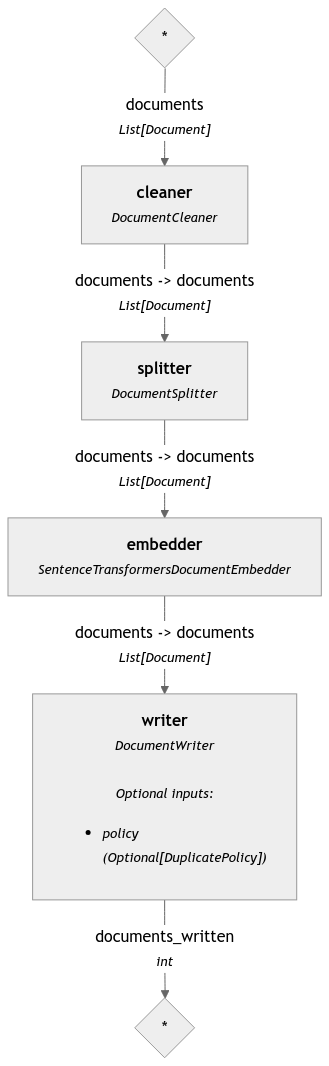

In [6]:
indexing = Pipeline()
indexing.add_component("cleaner", DocumentCleaner())
indexing.add_component("splitter", DocumentSplitter(split_by='sentence', split_length=2))
indexing.add_component("embedder", SentenceTransformersDocumentEmbedder(model=model_emb,
                                                                            device=ComponentDevice.from_str(device),
                                                                            meta_fields_to_embed=["title"]))
indexing.add_component("writer", DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE))

indexing.connect("cleaner", "splitter")
indexing.connect("splitter", "embedder")
indexing.connect("embedder", "writer")

indexing.run({"cleaner":{"documents": raw_docs}})
indexing.show()

Inspecting the Document Store:

In [7]:
num_documents = len(document_store.filter_documents())
print(f"Number of documents in store: {num_documents}")

document_meta = document_store.filter_documents()[0].meta
print("Metadata of document:", document_meta)


Number of documents in store: 1306
Metadata of document: {'title': 'FIFA World Cup', 'url': 'https://en.wikipedia.org/wiki/FIFA_World_Cup', 'source_id': '019091237080c1d52ababf9a11051c2c90933e79c19917e7af322bc15750c48c', 'page_number': 1, 'split_id': 0, 'split_idx_start': 0}


### The RAG Pipeline (Generate + Retrieve Stage)

In Haystack 2.0, we use the `HuggingFaceLocalGenerator` for managing Open Source LLMs. 

Our RAG Pipeline retrieves relevant documents based on the user's query and uses them to generate a grounded response with the LLM.

It consists of the following components:

- **`SentenceTransformersTextEmbedder`**: Encodes the user's query into a vector that captures its meaning.
- **`InMemoryEmbeddingRetriever`**: Finds the top 5 documents most similar to the query vector.
- **`PromptBuilder`**: Generates a prompt by rendering a template string using the Jinja2 engine.
- **`HuggingFaceLocalGenerator`**: Integrate Open Source LLMs from HuggingFace.

We start with `SmolLM2-1.7B-Instruct`, and later test smaller variants. The model is loaded with **4-bit quantization** using `huggingface_pipeline_kwargs` in the Generator.

In [15]:
generator = HuggingFaceLocalGenerator(
    "HuggingFaceTB/SmolLM2-135M-Instruct",
    huggingface_pipeline_kwargs={
        "device_map": "auto",
        # "model_kwargs": {
        #     "load_in_4bit": True,
        #     "bnb_4bit_use_double_quant": True,
        #     "bnb_4bit_quant_type": "nf4",
        #     "bnb_4bit_compute_dtype": torch.bfloat16
        # }
    },
    generation_kwargs={"max_new_tokens": 1000}
)
generator.warm_up()

In [16]:
prompt_template = """<|system|>Using the information contained in the context, give a conscise answer to the question.
If the answer is contained in the context, report the source URL.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
  {% for doc in documents %}
  {{ doc.content }} URL:{{ doc.meta['url'] }}
  {% endfor %};
  Question: {{query}}
  </s>
<|assistant|>
"""
prompt_builder = PromptBuilder(template=prompt_template)

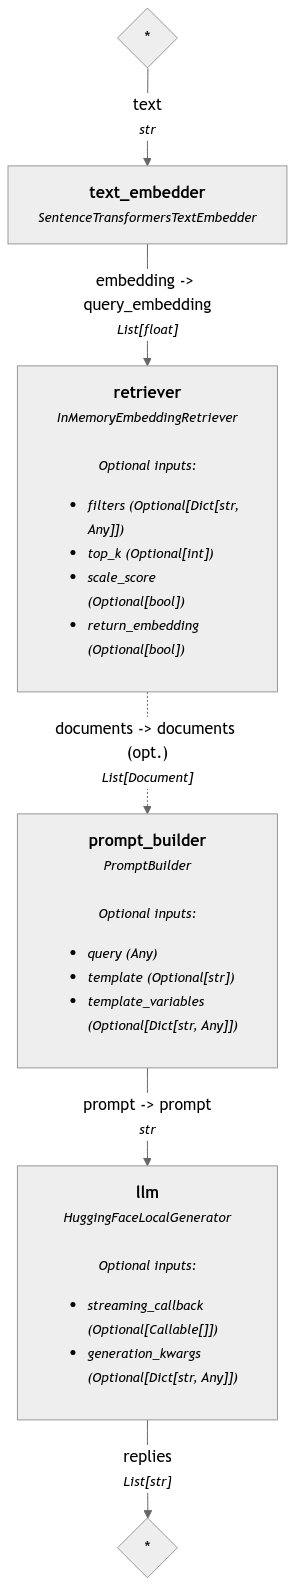

In [17]:
rag = Pipeline()
rag.add_component("text_embedder", SentenceTransformersTextEmbedder(model=model_emb,
                                                                    device=ComponentDevice.from_str(device)))
rag.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k=5))
rag.add_component("prompt_builder", prompt_builder)
rag.add_component("llm", generator)

rag.connect("text_embedder", "retriever")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder.prompt", "llm.prompt")

rag.show()

In [11]:
def get_answer(query):

  results = rag.run({
      "text_embedder": {"text": query},
      "prompt_builder": {"query": query}
    }
  )

  answer = results["llm"]["replies"][0]
  return answer

print(get_answer("What is RAG?"))

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


<|system|>Using the information contained in the context, give a comprehensive answer to the question.
If the answer is contained in the context, also report the source URL.
If the answer cannot be deduced from the context, do not give an answer.</s>
<|user|>
Context:
  
  8 in) deep.
Its main body is solid sterling silver and silver gilt, whilst its plinth is made of malachite, a semi-precious stone. URL:https://en.wikipedia.org/wiki/Premier_League
  
   The Premier League players decided to take the knee at selected "significant moments". They assured to "remain resolutely committed to eradicate racial prejudice". URL:https://en.wikipedia.org/wiki/Premier_League
  
   In the cases of Bayer Leverkusen and Wolfsburg, the clubs were founded by major corporations (respectively Bayer AG and Volkswagen) as sports clubs for their employees, while Hoffenheim has long received its primary support from SAP co-founder Dietmar Hopp, who played in the club's youth system.
After 2000 the German F

In [12]:
questions = """
What was the result of the latest FIFA World Cup?
Who won the last UEFA Champions League?
Which country won the most recent Copa América?
What is the top scorer in the CONCACAF Gold Cup this year?
Which teams participated in the latest Africa Cup of Nations?
Who won the last Copa Libertadores?
What were the standout performances in UEFA Euro 2020?
Who is the current champion of Major League Soccer (MLS)?
What is the top team in the Premier League this season?
Who won La Liga this year?
Which Bundesliga team has the most titles in the last decade?
Which Serie A team won the last league championship?
Who is the top scorer of Ligue 1 this season?
Who won the UEFA Euro Golden Boot in the last competition?
Who won the most recent Ballon d'Or?
""".split('\n')

In [18]:
q = random.choice(questions)
print(q)
print(get_answer(q))

Which Bundesliga team has the most titles in the last decade?


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


<|user|>
Context:
  
   The Bundesliga is one of the most prestigious leagues in Germany, ranked 16th in the world in 2024. The league is divided into 12 teams, each with 12 members. The league is divided into 12 Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bundesliga Bunde